
# **Data preparation**

Creating a dataset that is compatible with torch.DataLoader


In [97]:
# importing packages

import numpy as np
import pandas as pd
import torch as tc

from pathlib import Path
from PIL import Image

from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2

Transforming images to make them compatible for CNN

In [98]:
# Training: met augmentation
TRANSFORM_TRAIN = v2.Compose([
    v2.ToImage(),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomRotation(15),
    v2.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    v2.RandomResizedCrop(160, scale=(0.8, 1.0)),
    v2.ToDtype(tc.float32, scale=True),
])

# Validation/Test: zonder augmentation
TRANSFORM_VAL = v2.Compose([
    v2.ToImage(),
    v2.Resize((160, 160)),
    v2.ToDtype(tc.float32, scale=True),
])

In [99]:
DATA_DIR = Path("/kaggle/input/feathers-in-focus-model/aml-2025-feathers-in-focus")

attributes = np.load(DATA_DIR / "attributes.npy")

In [100]:
train_df = pd.read_csv("/kaggle/input/feathers-in-focus-model//aml-2025-feathers-in-focus/train_images.csv")
print(train_df.head())

            image_path  label
0  /train_images/1.jpg      1
1  /train_images/2.jpg      1
2  /train_images/3.jpg      1
3  /train_images/4.jpg      1
4  /train_images/5.jpg      1


Defining the type and config parameters of the data

In [101]:
# idx, image, label, path

ItemType = tuple[int, tc.Tensor, int, tc.Tensor, str] 

Define how to read a sample given the index

In [102]:
class ImageClassification(Dataset):
    def __init__(
        self,
        df: pd.DataFrame,
        search_root: Path,
        attributes: np.ndarray = None,
        transform: v2.Transform = TRANSFORM_DEFAULT,
    ):
        self.df = df.reset_index(drop=True)
        self.search_root = search_root
        self.transform = transform
        self.attributes = tc.tensor(attributes, dtype=tc.float32) if attributes is not None else None  

    def __len__(self) -> int:
        return len(self.df)
    
    def _find_image_path(self, filename: str) -> Path:
        path = self.search_root / filename.lstrip('/')
        if not path.exists():
            raise FileNotFoundError(f"Image file '{filename}' not found at {path}")
        return path

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        filename = Path(str(row["image_path"])).name
        path = self._find_image_path(filename)
        
        image = Image.open(path).convert("RGB")
        image = self.transform(image)
        
        if "label" in row.index and self.attributes is not None:
            label = int(row["label"]) - 1
            attr = self.attributes[label]
            return idx, image, label, attr, str(path)
        else:
            return idx, image, str(path)

Check if set-up works

In [103]:
attributes = np.load("/kaggle/input/feathers-in-focus-model/aml-2025-feathers-in-focus/attributes.npy")

SEARCH_ROOT = Path("/kaggle/input/feathers-in-focus-model/aml-2025-feathers-in-focus/train_images")

# Train dataset MET augmentation
train_dataset = ImageClassification(
    df=train_df,
    search_root=SEARCH_ROOT,
    attributes=attributes,
    transform=TRANSFORM_TRAIN,  # ← augmentation
)

# Split VOOR je transforms toepast
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_set, val_set = random_split(train_dataset, [train_size, val_size])

# Overschrijf validation transform (belangrijk!)
val_set.dataset.transform = TRANSFORM_VAL

idx0, img0, label0, attr0, path0 = train_dataset[0] 
print("Pad eerste image:", path0)
print("Image shape:", img0.shape)
print("Label:", label0)
print("Attributes shape:", attr0.shape)  

Pad eerste image: /kaggle/input/feathers-in-focus-model/aml-2025-feathers-in-focus/train_images/1.jpg
Image shape: torch.Size([3, 160, 160])
Label: 0
Attributes shape: torch.Size([312])


Splitting the data in training and validation set (80/20) and creating DataLoader batches

In [104]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Train/validation split
from torch.utils.data import random_split

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_set, val_set = random_split(train_dataset, [train_size, val_size])

# DataLoaders batches
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)  
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)

# **CREATING, TRAINING, VALIDATING MODEL**

In [105]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR

from pathlib import Path

In [106]:
DATA_DIR  = Path("/kaggle/input/feathers-in-focus-model/aml-2025-feathers-in-focus")

In [107]:
def load_argparser():
    parser = argparse.ArgumentParser(description="Feathers in Focus")
    parser.add.argument("--batch-size", type=int, default=64)
    parser.add.argument("__test-batch-size", type=int, default=1000)
    parser.add.argument("--epochs", type=int, default=14)
    parser.add.argument("--lr", type=float, default=1.0)
    parder.add.argument("--gamma", type=float, default=0.7)
    parser.add.argument("--dry-run", action="store_true")
    parser.add.argument("--seed", type=int, default=1)
    parser.add.argument("--log-interval", type=int, default=10)
    parder.add.argument("--save-model", action="store_true")
    return parser

##### **Defining the model to use**

Model with 4 convolional layers (RGB, simple features, complex pattorns, higher level features). 
This leads to a fully convolutional layer with 9216 input and 128 output. 
This leads to 200 classes, bird species. 

**Forward pass**

Forward pass trough the model, using the 4 convolutional layers, combined with the ReLu activation function for non-linearity. Making use of max pooling and creating the fully connected layer followed by the output layer and softmax function. 

In [108]:
class DeeperNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            # Layer 1: 224 → 112
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Layer 2: 112 → 56
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Layer 3: 56 → 28
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Layer 4: 28 → 14
            nn.Conv2d(256, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            # Layer 5: 14 → 1 (adaptive)
            nn.Conv2d(512, 512, 3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
        )
        
        self.class_head = nn.Linear(256, 200)
        self.attr_head = nn.Linear(256, 312)
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        class_out = F.log_softmax(self.class_head(x), dim=1)
        attr_out = torch.sigmoid(self.attr_head(x))
        return class_out, attr_out

**Training loop: forward - backward propagation**

From forward pass, to calculating the loss, to backward propagation calculating the gradient to adjusting the weights. 

In [109]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (idx, data, target, attr_target, path) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        attr_target = attr_target.to(device)
        
        optimizer.zero_grad()
        class_output, attr_output = model(data) 
        
        # Gecombineerde loss
        class_loss = F.nll_loss(class_output, target)
        attr_loss = F.mse_loss(attr_output, attr_target) 
        loss = class_loss + 0.3 * attr_loss 
        
        loss.backward()
        optimizer.step()

        if batch_idx % 10 == 0:
            print(f"Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}] "
                  f"Loss: {loss.item():.6f} (class: {class_loss.item():.4f}, attr: {attr_loss.item():.4f})")

**Testing / validation loop**

In [110]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for idx, data, target, attr_target, path in test_loader:
            data = data.to(device)
            target = target.to(device)
            
            class_output, attr_output = model(data) 
            test_loss += F.nll_loss(class_output, target, reduction="sum").item()
            pred = class_output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f"Val set: Avg loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)")

In [111]:
# Config
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
EPOCHS = 20
LR = 0.002

model = DeeperNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)

for epoch in range(1, EPOCHS + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, val_loader)

torch.save(model.state_dict(), "bird_cnn.pt")

Epoch: 1 [0/3140] Loss: 5.388991 (class: 5.3199, attr: 0.2303)
Epoch: 1 [640/3140] Loss: 5.423028 (class: 5.4059, attr: 0.0572)
Epoch: 1 [1280/3140] Loss: 5.313406 (class: 5.3025, attr: 0.0364)
Epoch: 1 [1920/3140] Loss: 5.400873 (class: 5.3926, attr: 0.0275)
Epoch: 1 [2560/3140] Loss: 5.178520 (class: 5.1745, attr: 0.0135)
Val set: Avg loss: 5.1168, Accuracy: 10/786 (1.27%)
Epoch: 2 [0/3140] Loss: 5.051024 (class: 5.0473, attr: 0.0125)
Epoch: 2 [640/3140] Loss: 5.027160 (class: 5.0249, attr: 0.0075)
Epoch: 2 [1280/3140] Loss: 5.029325 (class: 5.0282, attr: 0.0039)
Epoch: 2 [1920/3140] Loss: 4.956396 (class: 4.9549, attr: 0.0048)
Epoch: 2 [2560/3140] Loss: 5.196087 (class: 5.1939, attr: 0.0072)
Val set: Avg loss: 5.1553, Accuracy: 18/786 (2.29%)
Epoch: 3 [0/3140] Loss: 4.960833 (class: 4.9570, attr: 0.0129)
Epoch: 3 [640/3140] Loss: 5.052901 (class: 5.0520, attr: 0.0028)
Epoch: 3 [1280/3140] Loss: 5.034160 (class: 5.0326, attr: 0.0052)
Epoch: 3 [1920/3140] Loss: 5.049981 (class: 5.0479

**Creating predictions on the test set and creating a file for submission in Kaggle**

In [112]:
test_df = pd.read_csv("/kaggle/input/feathers-in-focus-model/aml-2025-feathers-in-focus/test_images_path.csv")
test_dataset = ImageClassification(
    df=test_df,
    search_root=Path("/kaggle/input/feathers-in-focus-model/aml-2025-feathers-in-focus/test_images"),
    transform=TRANSFORM_DEFAULT,
    attributes=None, 
)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
predictions = []

with torch.no_grad():
    for idx, data, path in test_loader:
        data = data.to(device)
        class_output, attr_output = model(data)
        pred = class_output.argmax(dim=1) + 1
        predictions.extend(pred.tolist())

submission = pd.DataFrame({
    "id": test_df["id"].values,
    "label": predictions
})
submission.to_csv("submission.csv", index=False)

print(f"Aantal predictions: {len(predictions)}")
print(f"Aantal test samples: {len(test_df)}")
print(submission.head(10))

Aantal predictions: 4000
Aantal test samples: 4000
   id  label
0   1     17
1   2     55
2   3     29
3   4     32
4   5     32
5   6     88
6   7     22
7   8     62
8   9     18
9  10     18


**Evaluation of the results**

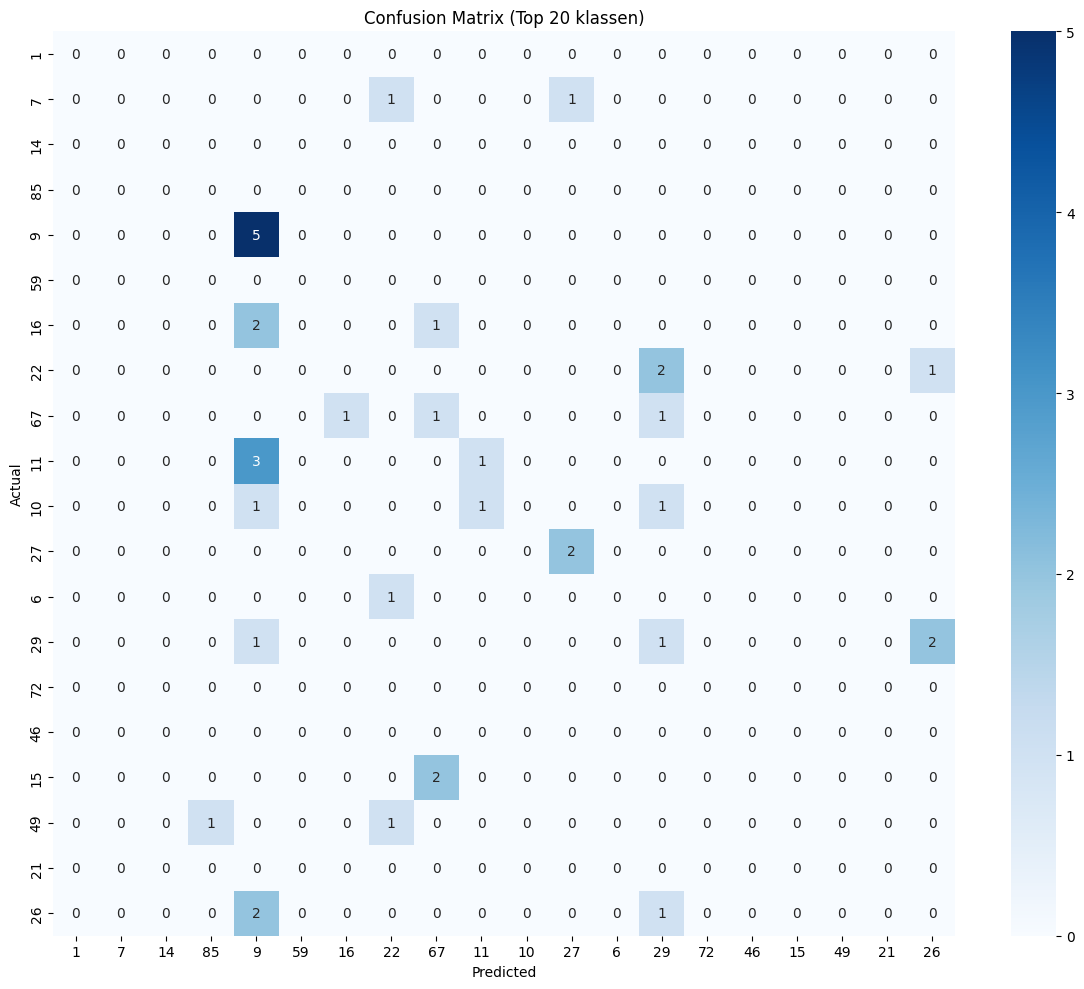


Top 10 meest verwarde klassen:
Actual → Predicted (aantal keer)
  Klasse 14 → Klasse 31: 4x
  Klasse 49 → Klasse 0: 4x
  Klasse 11 → Klasse 9: 3x
  Klasse 20 → Klasse 9: 3x
  Klasse 21 → Klasse 3: 3x
  Klasse 24 → Klasse 22: 3x
  Klasse 26 → Klasse 3: 3x
  Klasse 27 → Klasse 3: 3x
  Klasse 32 → Klasse 31: 3x
  Klasse 39 → Klasse 43: 3x

ROC AUC kon niet berekend worden: Number of classes in y_true not equal to the number of columns in 'y_score'

Classification Report (macro avg):
  0.00      0.00      0.00         1

    accuracy                           0.05       786
   macro avg       0.02      0.04      0.02       786
weighted avg       0.02      0.05      0.03       786



In [113]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import torch.nn.functional as F

model.eval()
all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for idx, data, target, attr, path in val_loader:
        data = data.to(device)
        class_output, attr_output = model(data)
        
        probs = torch.exp(class_output)  # log_softmax → probabilities
        preds = class_output.argmax(dim=1)
        
        all_probs.append(probs.cpu())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(target.numpy())

all_probs = torch.cat(all_probs).numpy()
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

cm = confusion_matrix(all_labels, all_preds)

top_classes = np.argsort(np.bincount(all_labels))[-20:]
cm_top = cm[np.ix_(top_classes, top_classes)]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_top, annot=True, fmt='d', cmap='Blues',
            xticklabels=top_classes, yticklabels=top_classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Top 20 klassen)')
plt.tight_layout()
plt.savefig('confusion_matrix.png')
plt.show()

np.fill_diagonal(cm, 0)  
confused_pairs = []
for i in range(len(cm)):
    for j in range(len(cm)):
        if cm[i, j] > 0:
            confused_pairs.append((i, j, cm[i, j]))

confused_pairs.sort(key=lambda x: x[2], reverse=True)
print("\nTop 10 meest verwarde klassen:")
print("Actual → Predicted (aantal keer)")
for actual, pred, count in confused_pairs[:10]:
    print(f"  Klasse {actual} → Klasse {pred}: {count}x")

try:
    roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr', average='macro')
    print(f"\nROC AUC (macro): {roc_auc:.4f}")
except ValueError as e:
    print(f"\nROC AUC kon niet berekend worden: {e}")

print("\nClassification Report (macro avg):")
print(classification_report(all_labels, all_preds, zero_division=0, 
                            output_dict=False, target_names=None)[-200:]) 

**Creating visualisation of the CNN model**

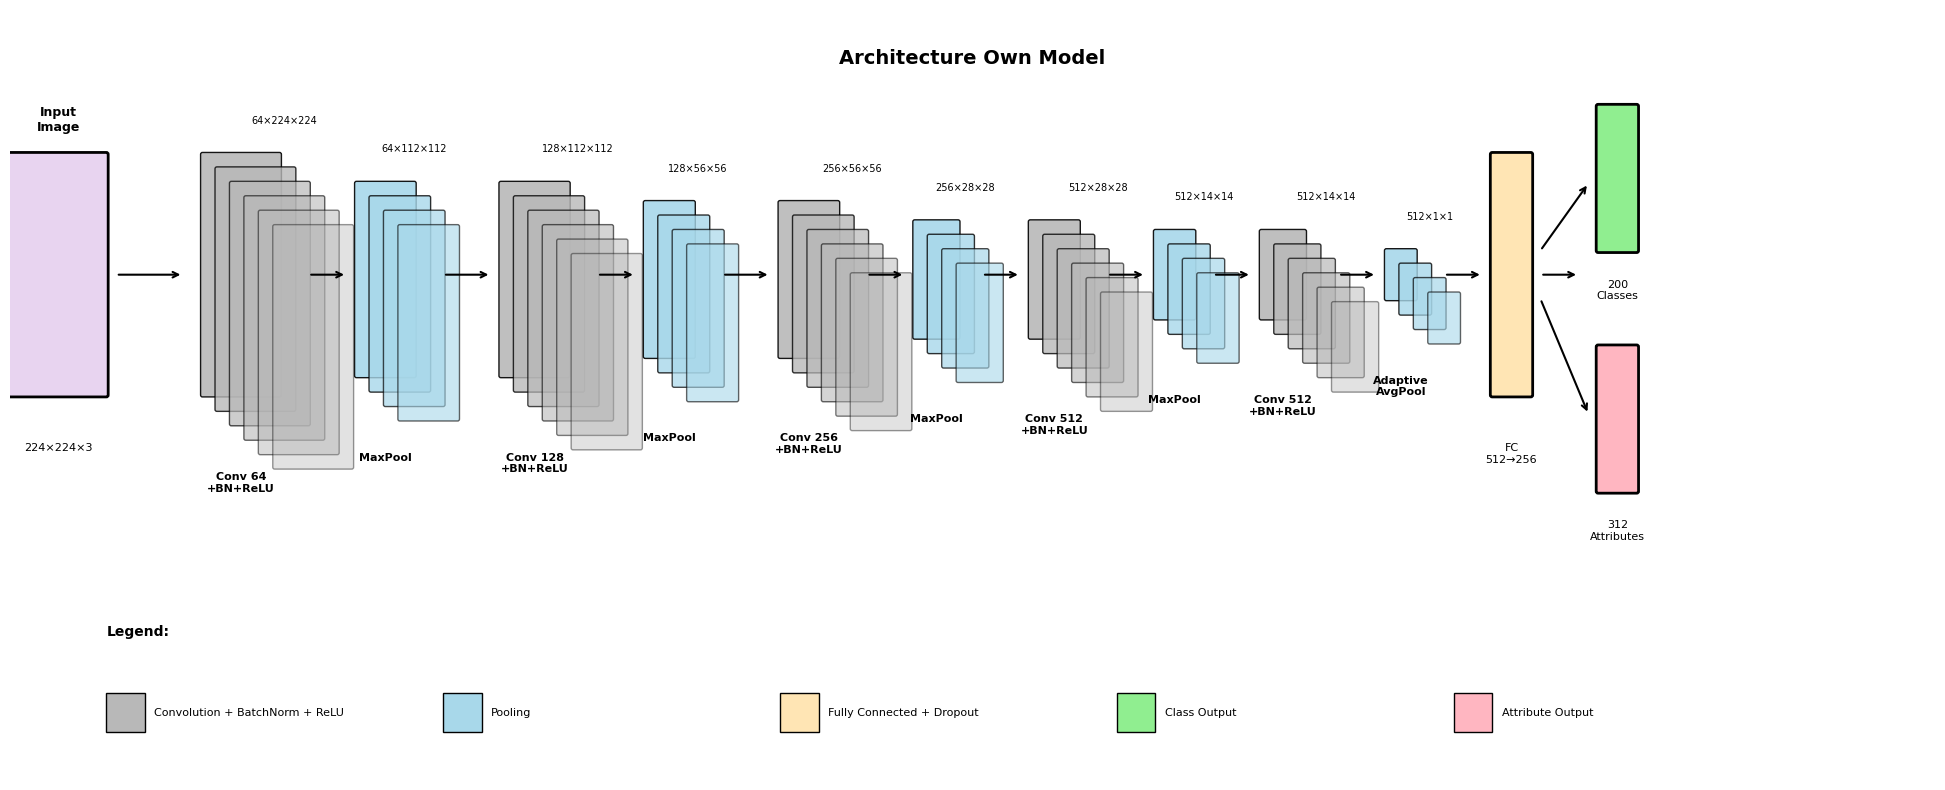

In [115]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

fig, ax = plt.subplots(1, 1, figsize=(20, 8))
ax.set_xlim(0, 20)
ax.set_ylim(0, 8)
ax.set_aspect('equal')
ax.axis('off')

color_input = '#E8D4F0'
color_conv = '#B8B8B8'
color_pool = '#A8D8EA'
color_fc = '#FFE5B4'

def draw_layer_stack(ax, x, y, width, height, depth, color, label_below=None, label_above=None):
    """Tekent een stack van layers (3D effect)"""
    for i in range(min(depth, 6)):  
        offset = i * 0.15
        rect = patches.FancyBboxPatch(
            (x + offset, y - offset), width, height,
            boxstyle="round,pad=0.02",
            facecolor=color, edgecolor='black', linewidth=1,
            alpha=0.9 - i*0.1
        )
        ax.add_patch(rect)
    
    if label_below:
        ax.text(x + width/2, y - 0.8, label_below, ha='center', va='top', fontsize=8, fontweight='bold')
    if label_above:
        ax.text(x + width/2 + depth*0.15/2, y + height + 0.3, label_above, ha='center', va='bottom', fontsize=7)

def draw_arrow(ax, x1, y1, x2, y2):
    ax.annotate('', xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle='->', color='black', lw=1.5))

ax.text(0.5, 7, 'Input\nImage', ha='center', va='top', fontsize=9, fontweight='bold')
rect = patches.FancyBboxPatch((0, 4), 1, 2.5, boxstyle="round,pad=0.02",
                               facecolor=color_input, edgecolor='black', linewidth=2)
ax.add_patch(rect)
ax.text(0.5, 3.5, '224×224×3', ha='center', va='top', fontsize=8)

draw_arrow(ax, 1.1, 5.25, 1.8, 5.25)

draw_layer_stack(ax, 2, 4, 0.8, 2.5, 6, color_conv, 
                 label_below='Conv 64\n+BN+ReLU', label_above='64×224×224')
draw_arrow(ax, 3.1, 5.25, 3.5, 5.25)
draw_layer_stack(ax, 3.6, 4.2, 0.6, 2, 4, color_pool,
                 label_below='MaxPool', label_above='64×112×112')

draw_arrow(ax, 4.5, 5.25, 5, 5.25)

draw_layer_stack(ax, 5.1, 4.2, 0.7, 2, 6, color_conv,
                 label_below='Conv 128\n+BN+ReLU', label_above='128×112×112')
draw_arrow(ax, 6.1, 5.25, 6.5, 5.25)
draw_layer_stack(ax, 6.6, 4.4, 0.5, 1.6, 4, color_pool,
                 label_below='MaxPool', label_above='128×56×56')

draw_arrow(ax, 7.4, 5.25, 7.9, 5.25)

draw_layer_stack(ax, 8, 4.4, 0.6, 1.6, 6, color_conv,
                 label_below='Conv 256\n+BN+ReLU', label_above='256×56×56')
draw_arrow(ax, 8.9, 5.25, 9.3, 5.25)
draw_layer_stack(ax, 9.4, 4.6, 0.45, 1.2, 4, color_pool,
                 label_below='MaxPool', label_above='256×28×28')

draw_arrow(ax, 10.1, 5.25, 10.5, 5.25)

draw_layer_stack(ax, 10.6, 4.6, 0.5, 1.2, 6, color_conv,
                 label_below='Conv 512\n+BN+ReLU', label_above='512×28×28')
draw_arrow(ax, 11.4, 5.25, 11.8, 5.25)
draw_layer_stack(ax, 11.9, 4.8, 0.4, 0.9, 4, color_pool,
                 label_below='MaxPool', label_above='512×14×14')

draw_arrow(ax, 12.5, 5.25, 12.9, 5.25)

draw_layer_stack(ax, 13, 4.8, 0.45, 0.9, 6, color_conv,
                 label_below='Conv 512\n+BN+ReLU', label_above='512×14×14')
draw_arrow(ax, 13.8, 5.25, 14.2, 5.25)
draw_layer_stack(ax, 14.3, 5, 0.3, 0.5, 4, color_pool,
                 label_below='Adaptive\nAvgPool', label_above='512×1×1')

draw_arrow(ax, 14.9, 5.25, 15.3, 5.25)

rect = patches.FancyBboxPatch((15.4, 4), 0.4, 2.5, boxstyle="round,pad=0.02",
                               facecolor=color_fc, edgecolor='black', linewidth=2)
ax.add_patch(rect)
ax.text(15.6, 3.5, 'FC\n512→256', ha='center', va='top', fontsize=8)

draw_arrow(ax, 15.9, 5.25, 16.3, 5.25)

rect = patches.FancyBboxPatch((16.5, 5.5), 0.4, 1.5, boxstyle="round,pad=0.02",
                               facecolor='#90EE90', edgecolor='black', linewidth=2)
ax.add_patch(rect)
ax.text(16.7, 5.2, '200\nClasses', ha='center', va='top', fontsize=8)

draw_arrow(ax, 15.9, 5.5, 16.4, 6.2)

rect = patches.FancyBboxPatch((16.5, 3), 0.4, 1.5, boxstyle="round,pad=0.02",
                               facecolor='#FFB6C1', edgecolor='black', linewidth=2)
ax.add_patch(rect)
ax.text(16.7, 2.7, '312\nAttributes', ha='center', va='top', fontsize=8)

draw_arrow(ax, 15.9, 5, 16.4, 3.8)

ax.text(1, 1.5, 'Legend:', fontsize=10, fontweight='bold')
legend_items = [
    (color_conv, 'Convolution + BatchNorm + ReLU'),
    (color_pool, 'Pooling'),
    (color_fc, 'Fully Connected + Dropout'),
    ('#90EE90', 'Class Output'),
    ('#FFB6C1', 'Attribute Output')
]
for i, (color, label) in enumerate(legend_items):
    rect = patches.Rectangle((1 + i*3.5, 0.5), 0.4, 0.4, facecolor=color, edgecolor='black')
    ax.add_patch(rect)
    ax.text(1.5 + i*3.5, 0.7, label, fontsize=8, va='center')

ax.text(10, 7.5, 'Architecture Own Model', 
        ha='center', va='center', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('deepernet_architecture.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()